In [2]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

In [4]:
borrar = ["Opportunity_Name", "ID", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "Actual_Delivery_Date", "Last_Activity", 
          "ASP_converted_Currency", "Prod_Category_A", "Product_Name", "Delivery_Year", "Month", 
          "TRF", "Product_Family", "Account_Name"]

useless = ["Submitted_for_Approval", "Account_Type", "Delivery_Terms", "Size", "Price", "ASP_Currency", 
           "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type"] # "Product_Category_B", "Region"]

dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date"]

target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [5]:
def preprocess(data):
    
    # elimino caracteres prohibidos
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days
    data["Same_Owner"] = data.Opportunity_Owner == data.Last_Modified_By
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    data.loc[data.TRF == 0, "TRF_Cat"] = 0
    data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    data.loc[data.TRF > 7, "TRF_Cat"] = 2
    data["Sales"] = data.groupby("Account_Name", sort = False)["Account_Name"].transform("count")
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(borrar + useless + dates, axis = 1)
    
    return (data)

In [6]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer

In [7]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [15]:
prep = preprocess(data)
prep = prep[(prep.Stage == "Closed Won") | (prep.Stage == "Closed Lost")]
prep.Stage = prep.Stage.replace({"Closed Won": 1, "Closed Lost": 0})

In [18]:
label_enc = LabelEncoder()

In [20]:
cat_vars = [x for x in prep.select_dtypes('category').columns if x != 'Stage']

In [25]:
for col in cat_vars:
    prep[col] = label_enc.fit_transform(prep[col])

In [27]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size=0.3, random_state=0)

In [29]:
model = xgb.XGBClassifier(learning_rate=0.015, 
                          booster='gbtree',
                          objective='binary:logistic',
                          n_estimators=5000)

In [59]:
model.fit(x_train.drop(target, axis=1), 
          y_train, eval_metric='logloss', 
          eval_set=[(x_test.drop(target, axis=1), y_test)], 
          early_stopping_rounds=800)

[0]	validation_0-logloss:0.680482
Will train until validation_0-logloss hasn't improved in 800 rounds.
[1]	validation_0-logloss:0.668229
[2]	validation_0-logloss:0.65633
[3]	validation_0-logloss:0.644758
[4]	validation_0-logloss:0.633563
[5]	validation_0-logloss:0.62266
[6]	validation_0-logloss:0.612008
[7]	validation_0-logloss:0.60171
[8]	validation_0-logloss:0.59168
[9]	validation_0-logloss:0.581943
[10]	validation_0-logloss:0.572456
[11]	validation_0-logloss:0.563175
[12]	validation_0-logloss:0.554192
[13]	validation_0-logloss:0.545437
[14]	validation_0-logloss:0.536906
[15]	validation_0-logloss:0.528565
[16]	validation_0-logloss:0.520455
[17]	validation_0-logloss:0.512537
[18]	validation_0-logloss:0.504819
[19]	validation_0-logloss:0.497326
[20]	validation_0-logloss:0.489982
[21]	validation_0-logloss:0.482819
[22]	validation_0-logloss:0.475848
[23]	validation_0-logloss:0.469034
[24]	validation_0-logloss:0.462375
[25]	validation_0-logloss:0.455879
[26]	validation_0-logloss:0.449524


[230]	validation_0-logloss:0.137751
[231]	validation_0-logloss:0.137547
[232]	validation_0-logloss:0.137372
[233]	validation_0-logloss:0.137184
[234]	validation_0-logloss:0.137003
[235]	validation_0-logloss:0.136834
[236]	validation_0-logloss:0.136658
[237]	validation_0-logloss:0.136468
[238]	validation_0-logloss:0.136315
[239]	validation_0-logloss:0.136148
[240]	validation_0-logloss:0.135966
[241]	validation_0-logloss:0.135791
[242]	validation_0-logloss:0.135629
[243]	validation_0-logloss:0.135459
[244]	validation_0-logloss:0.135302
[245]	validation_0-logloss:0.135152
[246]	validation_0-logloss:0.13499
[247]	validation_0-logloss:0.134837
[248]	validation_0-logloss:0.134686
[249]	validation_0-logloss:0.134545
[250]	validation_0-logloss:0.13439
[251]	validation_0-logloss:0.134249
[252]	validation_0-logloss:0.134098
[253]	validation_0-logloss:0.133929
[254]	validation_0-logloss:0.1338
[255]	validation_0-logloss:0.133673
[256]	validation_0-logloss:0.133537
[257]	validation_0-logloss:0.133

[459]	validation_0-logloss:0.119604
[460]	validation_0-logloss:0.119575
[461]	validation_0-logloss:0.119471
[462]	validation_0-logloss:0.119414
[463]	validation_0-logloss:0.119416
[464]	validation_0-logloss:0.1193
[465]	validation_0-logloss:0.119226
[466]	validation_0-logloss:0.119174
[467]	validation_0-logloss:0.119128
[468]	validation_0-logloss:0.119026
[469]	validation_0-logloss:0.118959
[470]	validation_0-logloss:0.118963
[471]	validation_0-logloss:0.118937
[472]	validation_0-logloss:0.118887
[473]	validation_0-logloss:0.11889
[474]	validation_0-logloss:0.118779
[475]	validation_0-logloss:0.118715
[476]	validation_0-logloss:0.118689
[477]	validation_0-logloss:0.118566
[478]	validation_0-logloss:0.118517
[479]	validation_0-logloss:0.118521
[480]	validation_0-logloss:0.118451
[481]	validation_0-logloss:0.11833
[482]	validation_0-logloss:0.118312
[483]	validation_0-logloss:0.11829
[484]	validation_0-logloss:0.118237
[485]	validation_0-logloss:0.11824
[486]	validation_0-logloss:0.11821

[688]	validation_0-logloss:0.110121
[689]	validation_0-logloss:0.110117
[690]	validation_0-logloss:0.110077
[691]	validation_0-logloss:0.110007
[692]	validation_0-logloss:0.109995
[693]	validation_0-logloss:0.109977
[694]	validation_0-logloss:0.109977
[695]	validation_0-logloss:0.109943
[696]	validation_0-logloss:0.109907
[697]	validation_0-logloss:0.109887
[698]	validation_0-logloss:0.109836
[699]	validation_0-logloss:0.109788
[700]	validation_0-logloss:0.109727
[701]	validation_0-logloss:0.109723
[702]	validation_0-logloss:0.109665
[703]	validation_0-logloss:0.109621
[704]	validation_0-logloss:0.109612
[705]	validation_0-logloss:0.10961
[706]	validation_0-logloss:0.109533
[707]	validation_0-logloss:0.109486
[708]	validation_0-logloss:0.109438
[709]	validation_0-logloss:0.109385
[710]	validation_0-logloss:0.109377
[711]	validation_0-logloss:0.109377
[712]	validation_0-logloss:0.109346
[713]	validation_0-logloss:0.109331
[714]	validation_0-logloss:0.109293
[715]	validation_0-logloss:0.

[917]	validation_0-logloss:0.105053
[918]	validation_0-logloss:0.104999
[919]	validation_0-logloss:0.104999
[920]	validation_0-logloss:0.104967
[921]	validation_0-logloss:0.104924
[922]	validation_0-logloss:0.104897
[923]	validation_0-logloss:0.1049
[924]	validation_0-logloss:0.104895
[925]	validation_0-logloss:0.104884
[926]	validation_0-logloss:0.10487
[927]	validation_0-logloss:0.104851
[928]	validation_0-logloss:0.10484
[929]	validation_0-logloss:0.104815
[930]	validation_0-logloss:0.104808
[931]	validation_0-logloss:0.104755
[932]	validation_0-logloss:0.104754
[933]	validation_0-logloss:0.10474
[934]	validation_0-logloss:0.104703
[935]	validation_0-logloss:0.104696
[936]	validation_0-logloss:0.104687
[937]	validation_0-logloss:0.104686
[938]	validation_0-logloss:0.104643
[939]	validation_0-logloss:0.104632
[940]	validation_0-logloss:0.104616
[941]	validation_0-logloss:0.104618
[942]	validation_0-logloss:0.104609
[943]	validation_0-logloss:0.104605
[944]	validation_0-logloss:0.1046

[1142]	validation_0-logloss:0.101764
[1143]	validation_0-logloss:0.101745
[1144]	validation_0-logloss:0.10172
[1145]	validation_0-logloss:0.101679
[1146]	validation_0-logloss:0.101654
[1147]	validation_0-logloss:0.101638
[1148]	validation_0-logloss:0.101632
[1149]	validation_0-logloss:0.101612
[1150]	validation_0-logloss:0.101611
[1151]	validation_0-logloss:0.101572
[1152]	validation_0-logloss:0.101563
[1153]	validation_0-logloss:0.101564
[1154]	validation_0-logloss:0.101544
[1155]	validation_0-logloss:0.101551
[1156]	validation_0-logloss:0.101532
[1157]	validation_0-logloss:0.101532
[1158]	validation_0-logloss:0.101524
[1159]	validation_0-logloss:0.101519
[1160]	validation_0-logloss:0.101507
[1161]	validation_0-logloss:0.1015
[1162]	validation_0-logloss:0.101501
[1163]	validation_0-logloss:0.101501
[1164]	validation_0-logloss:0.101499
[1165]	validation_0-logloss:0.101482
[1166]	validation_0-logloss:0.101482
[1167]	validation_0-logloss:0.101482
[1168]	validation_0-logloss:0.101485
[116

[1364]	validation_0-logloss:0.099407
[1365]	validation_0-logloss:0.09939
[1366]	validation_0-logloss:0.099336
[1367]	validation_0-logloss:0.099315
[1368]	validation_0-logloss:0.09928
[1369]	validation_0-logloss:0.099283
[1370]	validation_0-logloss:0.099268
[1371]	validation_0-logloss:0.099216
[1372]	validation_0-logloss:0.099181
[1373]	validation_0-logloss:0.099163
[1374]	validation_0-logloss:0.099116
[1375]	validation_0-logloss:0.099066
[1376]	validation_0-logloss:0.099036
[1377]	validation_0-logloss:0.099039
[1378]	validation_0-logloss:0.099022
[1379]	validation_0-logloss:0.098988
[1380]	validation_0-logloss:0.098975
[1381]	validation_0-logloss:0.098927
[1382]	validation_0-logloss:0.098902
[1383]	validation_0-logloss:0.098879
[1384]	validation_0-logloss:0.098883
[1385]	validation_0-logloss:0.098842
[1386]	validation_0-logloss:0.098819
[1387]	validation_0-logloss:0.098804
[1388]	validation_0-logloss:0.098782
[1389]	validation_0-logloss:0.098762
[1390]	validation_0-logloss:0.098747
[13

[1586]	validation_0-logloss:0.096319
[1587]	validation_0-logloss:0.096321
[1588]	validation_0-logloss:0.09631
[1589]	validation_0-logloss:0.096306
[1590]	validation_0-logloss:0.096258
[1591]	validation_0-logloss:0.096255
[1592]	validation_0-logloss:0.09625
[1593]	validation_0-logloss:0.096243
[1594]	validation_0-logloss:0.096207
[1595]	validation_0-logloss:0.096208
[1596]	validation_0-logloss:0.096203
[1597]	validation_0-logloss:0.096167
[1598]	validation_0-logloss:0.096154
[1599]	validation_0-logloss:0.096146
[1600]	validation_0-logloss:0.096111
[1601]	validation_0-logloss:0.096087
[1602]	validation_0-logloss:0.096071
[1603]	validation_0-logloss:0.096071
[1604]	validation_0-logloss:0.096065
[1605]	validation_0-logloss:0.096064
[1606]	validation_0-logloss:0.096061
[1607]	validation_0-logloss:0.096032
[1608]	validation_0-logloss:0.096011
[1609]	validation_0-logloss:0.096001
[1610]	validation_0-logloss:0.096007
[1611]	validation_0-logloss:0.095992
[1612]	validation_0-logloss:0.095994
[16

[1808]	validation_0-logloss:0.09424
[1809]	validation_0-logloss:0.094243
[1810]	validation_0-logloss:0.094241
[1811]	validation_0-logloss:0.094229
[1812]	validation_0-logloss:0.094229
[1813]	validation_0-logloss:0.094221
[1814]	validation_0-logloss:0.09422
[1815]	validation_0-logloss:0.0942
[1816]	validation_0-logloss:0.094179
[1817]	validation_0-logloss:0.094179
[1818]	validation_0-logloss:0.094174
[1819]	validation_0-logloss:0.094154
[1820]	validation_0-logloss:0.094145
[1821]	validation_0-logloss:0.094147
[1822]	validation_0-logloss:0.094132
[1823]	validation_0-logloss:0.094132
[1824]	validation_0-logloss:0.094132
[1825]	validation_0-logloss:0.094111
[1826]	validation_0-logloss:0.094097
[1827]	validation_0-logloss:0.094052
[1828]	validation_0-logloss:0.094056
[1829]	validation_0-logloss:0.094042
[1830]	validation_0-logloss:0.094025
[1831]	validation_0-logloss:0.094016
[1832]	validation_0-logloss:0.094007
[1833]	validation_0-logloss:0.093994
[1834]	validation_0-logloss:0.093996
[1835

[2031]	validation_0-logloss:0.092777
[2032]	validation_0-logloss:0.092777
[2033]	validation_0-logloss:0.092784
[2034]	validation_0-logloss:0.09279
[2035]	validation_0-logloss:0.09279
[2036]	validation_0-logloss:0.092785
[2037]	validation_0-logloss:0.092782
[2038]	validation_0-logloss:0.092785
[2039]	validation_0-logloss:0.092777
[2040]	validation_0-logloss:0.092778
[2041]	validation_0-logloss:0.092783
[2042]	validation_0-logloss:0.092786
[2043]	validation_0-logloss:0.092789
[2044]	validation_0-logloss:0.092765
[2045]	validation_0-logloss:0.09277
[2046]	validation_0-logloss:0.092762
[2047]	validation_0-logloss:0.092769
[2048]	validation_0-logloss:0.092771
[2049]	validation_0-logloss:0.092774
[2050]	validation_0-logloss:0.092774
[2051]	validation_0-logloss:0.092762
[2052]	validation_0-logloss:0.092747
[2053]	validation_0-logloss:0.09275
[2054]	validation_0-logloss:0.092751
[2055]	validation_0-logloss:0.092763
[2056]	validation_0-logloss:0.092766
[2057]	validation_0-logloss:0.092764
[2058

[2253]	validation_0-logloss:0.091705
[2254]	validation_0-logloss:0.091696
[2255]	validation_0-logloss:0.0917
[2256]	validation_0-logloss:0.0917
[2257]	validation_0-logloss:0.091705
[2258]	validation_0-logloss:0.091685
[2259]	validation_0-logloss:0.091686
[2260]	validation_0-logloss:0.091679
[2261]	validation_0-logloss:0.091665
[2262]	validation_0-logloss:0.091663
[2263]	validation_0-logloss:0.091644
[2264]	validation_0-logloss:0.091627
[2265]	validation_0-logloss:0.091608
[2266]	validation_0-logloss:0.091594
[2267]	validation_0-logloss:0.091597
[2268]	validation_0-logloss:0.091594
[2269]	validation_0-logloss:0.091596
[2270]	validation_0-logloss:0.091596
[2271]	validation_0-logloss:0.091599
[2272]	validation_0-logloss:0.091603
[2273]	validation_0-logloss:0.091606
[2274]	validation_0-logloss:0.091589
[2275]	validation_0-logloss:0.09159
[2276]	validation_0-logloss:0.091597
[2277]	validation_0-logloss:0.091582
[2278]	validation_0-logloss:0.091564
[2279]	validation_0-logloss:0.091571
[2280]

[2476]	validation_0-logloss:0.090171
[2477]	validation_0-logloss:0.090179
[2478]	validation_0-logloss:0.090167
[2479]	validation_0-logloss:0.090161
[2480]	validation_0-logloss:0.09015
[2481]	validation_0-logloss:0.090158
[2482]	validation_0-logloss:0.090152
[2483]	validation_0-logloss:0.09015
[2484]	validation_0-logloss:0.090139
[2485]	validation_0-logloss:0.090136
[2486]	validation_0-logloss:0.09013
[2487]	validation_0-logloss:0.090104
[2488]	validation_0-logloss:0.090091
[2489]	validation_0-logloss:0.090104
[2490]	validation_0-logloss:0.090106
[2491]	validation_0-logloss:0.090108
[2492]	validation_0-logloss:0.090105
[2493]	validation_0-logloss:0.0901
[2494]	validation_0-logloss:0.090112
[2495]	validation_0-logloss:0.090085
[2496]	validation_0-logloss:0.09008
[2497]	validation_0-logloss:0.090093
[2498]	validation_0-logloss:0.09009
[2499]	validation_0-logloss:0.090095
[2500]	validation_0-logloss:0.090092
[2501]	validation_0-logloss:0.090074
[2502]	validation_0-logloss:0.090051
[2503]	v

[2699]	validation_0-logloss:0.089369
[2700]	validation_0-logloss:0.089353
[2701]	validation_0-logloss:0.089341
[2702]	validation_0-logloss:0.089336
[2703]	validation_0-logloss:0.089331
[2704]	validation_0-logloss:0.089324
[2705]	validation_0-logloss:0.089299
[2706]	validation_0-logloss:0.089288
[2707]	validation_0-logloss:0.089279
[2708]	validation_0-logloss:0.089282
[2709]	validation_0-logloss:0.089282
[2710]	validation_0-logloss:0.089264
[2711]	validation_0-logloss:0.089259
[2712]	validation_0-logloss:0.089255
[2713]	validation_0-logloss:0.089257
[2714]	validation_0-logloss:0.089254
[2715]	validation_0-logloss:0.089254
[2716]	validation_0-logloss:0.089255
[2717]	validation_0-logloss:0.089261
[2718]	validation_0-logloss:0.089261
[2719]	validation_0-logloss:0.089262
[2720]	validation_0-logloss:0.089261
[2721]	validation_0-logloss:0.089257
[2722]	validation_0-logloss:0.089249
[2723]	validation_0-logloss:0.089244
[2724]	validation_0-logloss:0.089252
[2725]	validation_0-logloss:0.089259
[

[2922]	validation_0-logloss:0.08884
[2923]	validation_0-logloss:0.088839
[2924]	validation_0-logloss:0.088833
[2925]	validation_0-logloss:0.088828
[2926]	validation_0-logloss:0.088828
[2927]	validation_0-logloss:0.088829
[2928]	validation_0-logloss:0.088819
[2929]	validation_0-logloss:0.088822
[2930]	validation_0-logloss:0.088806
[2931]	validation_0-logloss:0.088796
[2932]	validation_0-logloss:0.088804
[2933]	validation_0-logloss:0.088796
[2934]	validation_0-logloss:0.08879
[2935]	validation_0-logloss:0.088787
[2936]	validation_0-logloss:0.088775
[2937]	validation_0-logloss:0.088775
[2938]	validation_0-logloss:0.088771
[2939]	validation_0-logloss:0.088763
[2940]	validation_0-logloss:0.08875
[2941]	validation_0-logloss:0.08875
[2942]	validation_0-logloss:0.088751
[2943]	validation_0-logloss:0.088745
[2944]	validation_0-logloss:0.088739
[2945]	validation_0-logloss:0.088747
[2946]	validation_0-logloss:0.088742
[2947]	validation_0-logloss:0.088735
[2948]	validation_0-logloss:0.088739
[2949

[3144]	validation_0-logloss:0.088125
[3145]	validation_0-logloss:0.088125
[3146]	validation_0-logloss:0.088128
[3147]	validation_0-logloss:0.088133
[3148]	validation_0-logloss:0.088137
[3149]	validation_0-logloss:0.088127
[3150]	validation_0-logloss:0.088126
[3151]	validation_0-logloss:0.08812
[3152]	validation_0-logloss:0.088117
[3153]	validation_0-logloss:0.08812
[3154]	validation_0-logloss:0.08812
[3155]	validation_0-logloss:0.088105
[3156]	validation_0-logloss:0.088107
[3157]	validation_0-logloss:0.088105
[3158]	validation_0-logloss:0.088108
[3159]	validation_0-logloss:0.088111
[3160]	validation_0-logloss:0.088112
[3161]	validation_0-logloss:0.088109
[3162]	validation_0-logloss:0.088113
[3163]	validation_0-logloss:0.088107
[3164]	validation_0-logloss:0.088108
[3165]	validation_0-logloss:0.088114
[3166]	validation_0-logloss:0.088104
[3167]	validation_0-logloss:0.088108
[3168]	validation_0-logloss:0.088105
[3169]	validation_0-logloss:0.088095
[3170]	validation_0-logloss:0.088075
[317

[3366]	validation_0-logloss:0.087319
[3367]	validation_0-logloss:0.087304
[3368]	validation_0-logloss:0.087308
[3369]	validation_0-logloss:0.087311
[3370]	validation_0-logloss:0.087304
[3371]	validation_0-logloss:0.087307
[3372]	validation_0-logloss:0.087303
[3373]	validation_0-logloss:0.087306
[3374]	validation_0-logloss:0.087297
[3375]	validation_0-logloss:0.087297
[3376]	validation_0-logloss:0.087299
[3377]	validation_0-logloss:0.087299
[3378]	validation_0-logloss:0.087295
[3379]	validation_0-logloss:0.087294
[3380]	validation_0-logloss:0.087279
[3381]	validation_0-logloss:0.087267
[3382]	validation_0-logloss:0.087262
[3383]	validation_0-logloss:0.087257
[3384]	validation_0-logloss:0.087257
[3385]	validation_0-logloss:0.087257
[3386]	validation_0-logloss:0.087258
[3387]	validation_0-logloss:0.087259
[3388]	validation_0-logloss:0.087248
[3389]	validation_0-logloss:0.08724
[3390]	validation_0-logloss:0.087237
[3391]	validation_0-logloss:0.087229
[3392]	validation_0-logloss:0.087226
[3

[3589]	validation_0-logloss:0.086514
[3590]	validation_0-logloss:0.086523
[3591]	validation_0-logloss:0.086522
[3592]	validation_0-logloss:0.086524
[3593]	validation_0-logloss:0.086533
[3594]	validation_0-logloss:0.086522
[3595]	validation_0-logloss:0.086527
[3596]	validation_0-logloss:0.086523
[3597]	validation_0-logloss:0.08653
[3598]	validation_0-logloss:0.086529
[3599]	validation_0-logloss:0.086521
[3600]	validation_0-logloss:0.086516
[3601]	validation_0-logloss:0.086522
[3602]	validation_0-logloss:0.086511
[3603]	validation_0-logloss:0.086508
[3604]	validation_0-logloss:0.086506
[3605]	validation_0-logloss:0.086499
[3606]	validation_0-logloss:0.086489
[3607]	validation_0-logloss:0.086489
[3608]	validation_0-logloss:0.086494
[3609]	validation_0-logloss:0.086489
[3610]	validation_0-logloss:0.086483
[3611]	validation_0-logloss:0.08649
[3612]	validation_0-logloss:0.086495
[3613]	validation_0-logloss:0.086487
[3614]	validation_0-logloss:0.086481
[3615]	validation_0-logloss:0.086474
[36

[3811]	validation_0-logloss:0.086158
[3812]	validation_0-logloss:0.08616
[3813]	validation_0-logloss:0.086157
[3814]	validation_0-logloss:0.086152
[3815]	validation_0-logloss:0.086147
[3816]	validation_0-logloss:0.086146
[3817]	validation_0-logloss:0.086139
[3818]	validation_0-logloss:0.086135
[3819]	validation_0-logloss:0.086135
[3820]	validation_0-logloss:0.086128
[3821]	validation_0-logloss:0.086128
[3822]	validation_0-logloss:0.086138
[3823]	validation_0-logloss:0.086133
[3824]	validation_0-logloss:0.086119
[3825]	validation_0-logloss:0.086113
[3826]	validation_0-logloss:0.086107
[3827]	validation_0-logloss:0.086102
[3828]	validation_0-logloss:0.086098
[3829]	validation_0-logloss:0.0861
[3830]	validation_0-logloss:0.086107
[3831]	validation_0-logloss:0.086101
[3832]	validation_0-logloss:0.086103
[3833]	validation_0-logloss:0.086086
[3834]	validation_0-logloss:0.086079
[3835]	validation_0-logloss:0.086074
[3836]	validation_0-logloss:0.086076
[3837]	validation_0-logloss:0.086072
[383

[4033]	validation_0-logloss:0.085955
[4034]	validation_0-logloss:0.08596
[4035]	validation_0-logloss:0.085955
[4036]	validation_0-logloss:0.085955
[4037]	validation_0-logloss:0.085944
[4038]	validation_0-logloss:0.08596
[4039]	validation_0-logloss:0.085964
[4040]	validation_0-logloss:0.085968
[4041]	validation_0-logloss:0.085952
[4042]	validation_0-logloss:0.085947
[4043]	validation_0-logloss:0.085949
[4044]	validation_0-logloss:0.085944
[4045]	validation_0-logloss:0.085946
[4046]	validation_0-logloss:0.085953
[4047]	validation_0-logloss:0.08595
[4048]	validation_0-logloss:0.08594
[4049]	validation_0-logloss:0.085929
[4050]	validation_0-logloss:0.085928
[4051]	validation_0-logloss:0.085925
[4052]	validation_0-logloss:0.085929
[4053]	validation_0-logloss:0.085933
[4054]	validation_0-logloss:0.085935
[4055]	validation_0-logloss:0.085934
[4056]	validation_0-logloss:0.085933
[4057]	validation_0-logloss:0.085936
[4058]	validation_0-logloss:0.085933
[4059]	validation_0-logloss:0.085936
[4060

[4256]	validation_0-logloss:0.085802
[4257]	validation_0-logloss:0.085805
[4258]	validation_0-logloss:0.085797
[4259]	validation_0-logloss:0.085797
[4260]	validation_0-logloss:0.085797
[4261]	validation_0-logloss:0.085787
[4262]	validation_0-logloss:0.085784
[4263]	validation_0-logloss:0.085787
[4264]	validation_0-logloss:0.085789
[4265]	validation_0-logloss:0.085777
[4266]	validation_0-logloss:0.085778
[4267]	validation_0-logloss:0.085774
[4268]	validation_0-logloss:0.085774
[4269]	validation_0-logloss:0.085774
[4270]	validation_0-logloss:0.085765
[4271]	validation_0-logloss:0.085762
[4272]	validation_0-logloss:0.085764
[4273]	validation_0-logloss:0.085759
[4274]	validation_0-logloss:0.085761
[4275]	validation_0-logloss:0.085766
[4276]	validation_0-logloss:0.085767
[4277]	validation_0-logloss:0.085767
[4278]	validation_0-logloss:0.08577
[4279]	validation_0-logloss:0.085777
[4280]	validation_0-logloss:0.08579
[4281]	validation_0-logloss:0.08579
[4282]	validation_0-logloss:0.085788
[428

[4479]	validation_0-logloss:0.085733
[4480]	validation_0-logloss:0.085736
[4481]	validation_0-logloss:0.085741
[4482]	validation_0-logloss:0.085743
[4483]	validation_0-logloss:0.085737
[4484]	validation_0-logloss:0.085739
[4485]	validation_0-logloss:0.085734
[4486]	validation_0-logloss:0.08574
[4487]	validation_0-logloss:0.08574
[4488]	validation_0-logloss:0.085745
[4489]	validation_0-logloss:0.085748
[4490]	validation_0-logloss:0.085743
[4491]	validation_0-logloss:0.085738
[4492]	validation_0-logloss:0.085737
[4493]	validation_0-logloss:0.085745
[4494]	validation_0-logloss:0.085744
[4495]	validation_0-logloss:0.085736
[4496]	validation_0-logloss:0.085738
[4497]	validation_0-logloss:0.085733
[4498]	validation_0-logloss:0.085736
[4499]	validation_0-logloss:0.085728
[4500]	validation_0-logloss:0.085735
[4501]	validation_0-logloss:0.085746
[4502]	validation_0-logloss:0.085748
[4503]	validation_0-logloss:0.085745
[4504]	validation_0-logloss:0.085751
[4505]	validation_0-logloss:0.085757
[45

[4701]	validation_0-logloss:0.08567
[4702]	validation_0-logloss:0.085665
[4703]	validation_0-logloss:0.085658
[4704]	validation_0-logloss:0.085661
[4705]	validation_0-logloss:0.08567
[4706]	validation_0-logloss:0.085669
[4707]	validation_0-logloss:0.085667
[4708]	validation_0-logloss:0.085674
[4709]	validation_0-logloss:0.085666
[4710]	validation_0-logloss:0.085658
[4711]	validation_0-logloss:0.085652
[4712]	validation_0-logloss:0.085648
[4713]	validation_0-logloss:0.085662
[4714]	validation_0-logloss:0.085647
[4715]	validation_0-logloss:0.08565
[4716]	validation_0-logloss:0.085652
[4717]	validation_0-logloss:0.085647
[4718]	validation_0-logloss:0.08565
[4719]	validation_0-logloss:0.085644
[4720]	validation_0-logloss:0.085647
[4721]	validation_0-logloss:0.085642
[4722]	validation_0-logloss:0.085644
[4723]	validation_0-logloss:0.085645
[4724]	validation_0-logloss:0.085645
[4725]	validation_0-logloss:0.085646
[4726]	validation_0-logloss:0.085641
[4727]	validation_0-logloss:0.085639
[4728

[4923]	validation_0-logloss:0.085723
[4924]	validation_0-logloss:0.085717
[4925]	validation_0-logloss:0.085723
[4926]	validation_0-logloss:0.085714
[4927]	validation_0-logloss:0.085718
[4928]	validation_0-logloss:0.085713
[4929]	validation_0-logloss:0.085712
[4930]	validation_0-logloss:0.085713
[4931]	validation_0-logloss:0.08571
[4932]	validation_0-logloss:0.085711
[4933]	validation_0-logloss:0.08571
[4934]	validation_0-logloss:0.085708
[4935]	validation_0-logloss:0.085704
[4936]	validation_0-logloss:0.085699
[4937]	validation_0-logloss:0.085702
[4938]	validation_0-logloss:0.085693
[4939]	validation_0-logloss:0.085689
[4940]	validation_0-logloss:0.085685
[4941]	validation_0-logloss:0.085682
[4942]	validation_0-logloss:0.085683
[4943]	validation_0-logloss:0.08568
[4944]	validation_0-logloss:0.085681
[4945]	validation_0-logloss:0.085682
[4946]	validation_0-logloss:0.085692
[4947]	validation_0-logloss:0.085692
[4948]	validation_0-logloss:0.085696
[4949]	validation_0-logloss:0.085691
[495

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.015, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=5000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [61]:
y_pred = model.predict_proba(x_test.drop(target, axis=1))

In [62]:
x_test.Stage.head(10)

2040     0
4069     0
4230     1
578      1
12595    0
6042     1
2763     0
15932    0
2669     1
12803    0
Name: Stage, dtype: int64

In [63]:
res = y_pred[:,1]

In [64]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])

In [65]:
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [66]:
log_loss(answer["Stage"], answer["Prediction"])

0.09653155063201191

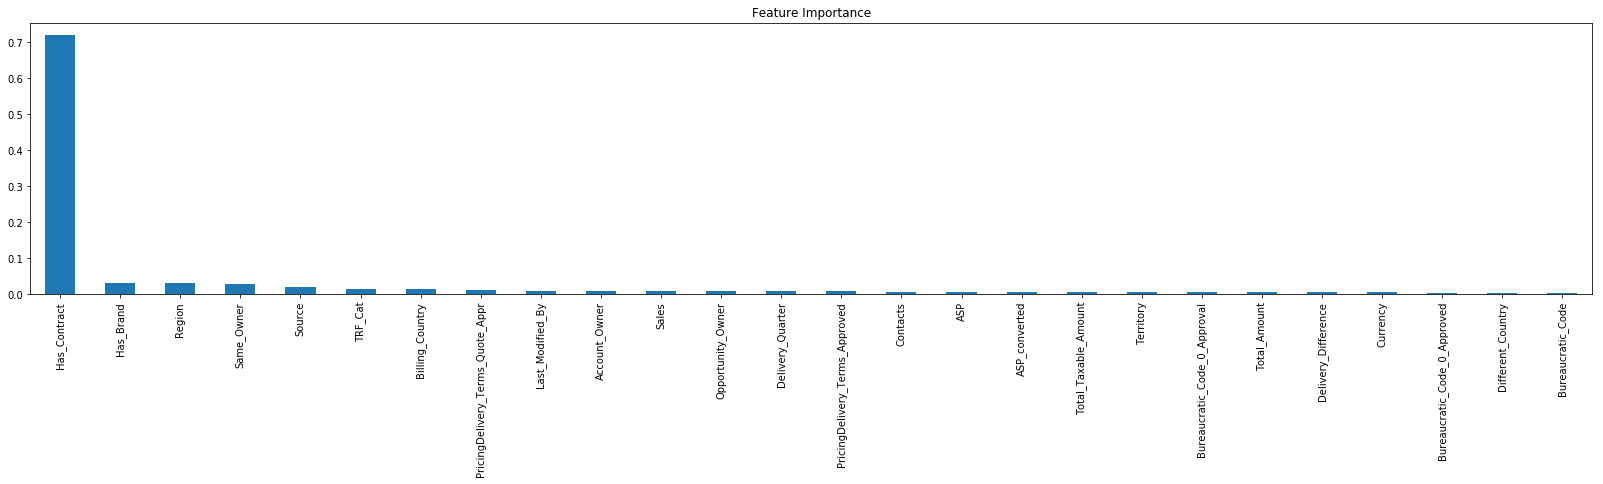

In [68]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [70]:
validation_file = "Validacion_ECI_2020.csv"
vali = pd.read_csv(validation_file)
validation = preprocess(vali)

In [72]:
for col in cat_vars:
    validation[col] = label_enc.fit_transform(validation[col])

In [74]:
validation.head()

,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Currency,Last_Modified_By,ASP,ASP_converted,Delivery_Quarter,Total_Amount,Total_Taxable_Amount,Contacts,Delivery_Difference,Same_Owner,Has_Brand,Has_Contract,Different_Country,TRF_Cat,Sales
0,2,14,1,1,1,1,3,10,12,10689,725,0,0,1,1,0.325,0.36761,1,162240.0,367419.0,3,30.0,True,False,True,False,0.0,30
1,2,14,1,1,1,1,3,10,12,10689,725,0,0,1,1,0.320,0.36195,1,78624.0,367419.0,3,30.0,True,False,True,False,0.0,30
2,2,14,1,1,1,1,3,10,12,10689,725,0,0,1,1,0.275,0.31105,1,126555.0,367419.0,3,30.0,True,False,True,False,0.0,30
3,2,14,1,1,1,1,3,10,12,10690,788,0,0,1,1,0.325,0.36761,1,243360.0,757783.5,5,27.0,True,False,True,False,1.0,30
4,2,14,1,1,1,1,3,10,12,10690,788,0,0,1,1,0.320,0.36195,1,157248.0,757783.5,5,28.0,True,False,True,False,0.0,30


In [78]:
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict_proba(validation.drop(leak, axis = 1))

In [81]:
pred_vali = pred[:,1]

In [84]:
pred = pd.DataFrame(pred_vali, index = validation.index, columns = ["Prediction"])
pred_vali = validation.join(pred)

In [89]:
answer = pd.DataFrame(pred_vali.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [94]:
model.fit(prep.drop(target, axis=1), 
          prep.Stage, eval_metric='logloss')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.015, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=5000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [96]:
y_pred_full = model.predict_proba(prep.drop(target, axis=1))
y_pred_full = y_pred_full[:,1]

In [102]:
pred = pd.DataFrame(y_pred_full, index = prep.index, columns = ["Prediction"])

In [104]:
pred_full = prep.join(pred)
answer_full = pred_full.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [106]:
log_loss(answer_full["Stage"], answer_full["Prediction"])

0.05342313995799043

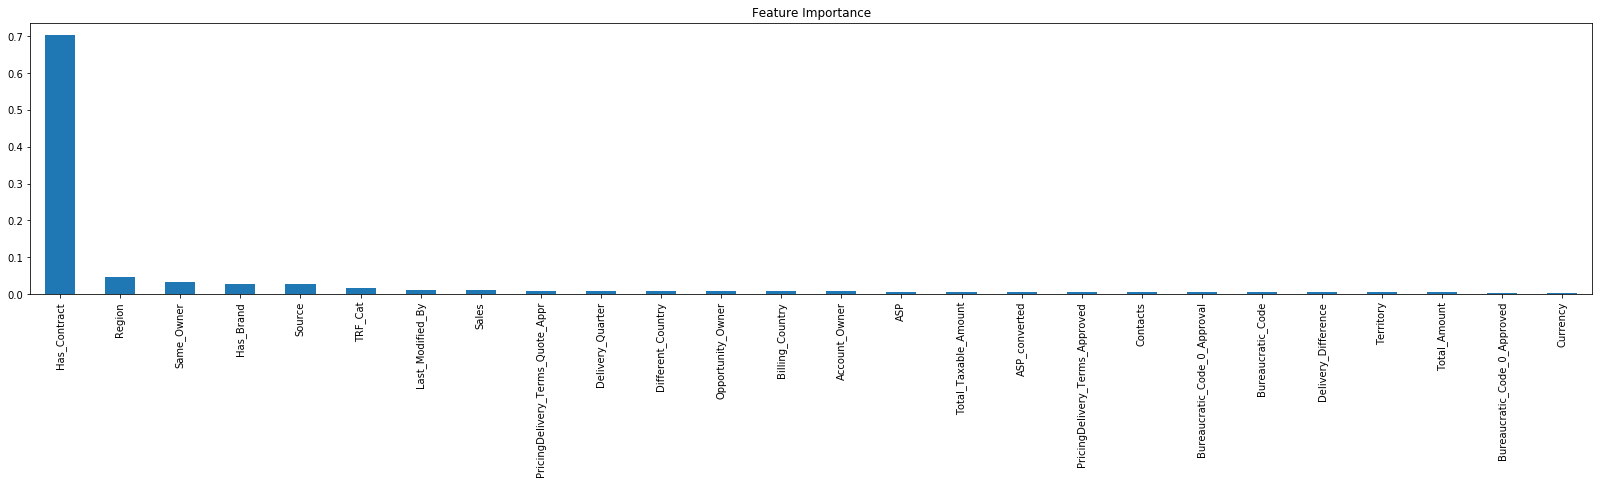

In [108]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:28]
plt.rcParams['figure.figsize'] = 28, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')